### Model Evaluation -- Algorithm Comparison (Nested Cross-Validation) with StratifiedKFold


In [19]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_gaussian_quantiles

In [20]:
def visualize_2d(X,y,title="2D Data ",figsize=(8,8)):
    import umap
    reducer = umap.UMAP()
    if X.shape[1]>2:
        X = reducer.fit_transform(X)
    else:
        if type(X)==pd.DataFrame:
        	X=X.values
    f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
    ax1.set_title(title);
    plt.show();

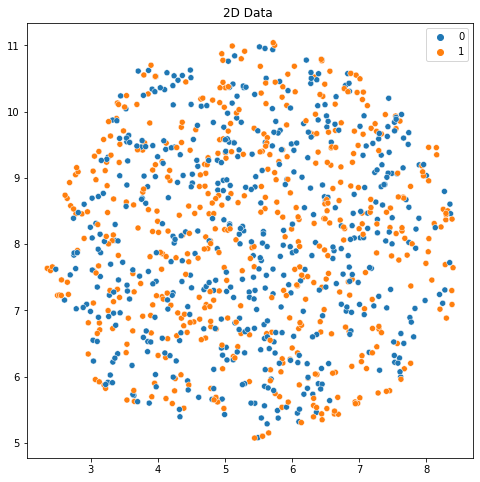

In [21]:
X_1, y_1 = make_gaussian_quantiles(n_samples= 1000,
                                 n_features=10,
                                 n_classes=2,
                                 )

# transform the dataset
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X1, y1 = ros.fit_resample(X_1, y_1)



X1 = pd.DataFrame(X1,columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])
y1 = pd.Series(y1)
visualize_2d(X1,y1)

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,
                                              test_size=0.25,
                                              random_state=1)

In [23]:

model1 = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
model2 = KNeighborsClassifier(n_neighbors=5)
model3 = DecisionTreeClassifier()
model4 = SVC(kernel= "rbf")
model5  = RandomForestClassifier(random_state=1)

In [24]:
# Setting up the parameter grids
opti_param_grid1 = {'n_estimators':[100, 500],
                     'max_depth': [1, 2, 3]}


opti_param_grid2 = {'n_neighbors': list(range(1, 10)),
                     'p': [1, 2]}

opti_param_grid3 = {'max_depth': list(range(1, 10)) + [None],
                    'criterion': ['gini', 'entropy']}

opti_param_grid4 = {'C': [0.01, 0.1, 1, 10, 100],
                    'gamma': [0.01, 0.1, 1, 10, 100]}
               

opti_param_grid5 = {'n_estimators': [10, 100, 500, 1000, 10000]}

In [25]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for pgrid, est, name in zip(( opti_param_grid1, opti_param_grid2,
                             opti_param_grid3, opti_param_grid4,opti_param_grid5),
                            (model1, model2, model3, model4, model5),
                            ('GBC', 'KNN', 'DTree', 'SVM', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [26]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=-1)
    print('%s | outer ACC %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))

DTree | outer ACC 70.40% +/- 5.02
GBC | outer ACC 90.53% +/- 3.12
KNN | outer ACC 65.20% +/- 3.70
RForest | outer ACC 81.87% +/- 4.31
SVM | outer ACC 95.87% +/- 1.73


In [27]:
gcv_model_select = GridSearchCV(estimator=model4,
                                param_grid=opti_param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [28]:
best_model = gcv_model_select.best_estimator_


## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# best_model.fit(X_train, y_train)


train_acc = accuracy_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('Accuracy %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training Accuracy: %.2f%%' % (100 * train_acc))
print('Test Accuracy: %.2f%%' % (100 * test_acc))

Accuracy 96.27% (average over k-fold CV test folds)
Best Parameters: {'C': 10, 'gamma': 0.1}
Training Accuracy: 100.00%
Test Accuracy: 94.80%


In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
randomizedscvs = {}
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for pgrid, est, name in zip(( opti_param_grid1, opti_param_grid2,
                             opti_param_grid3, opti_param_grid4, opti_param_grid5),
                            (model1, model2, model3, model4, model5),
                            ('GBC', 'KNN', 'DTree', 'SVM', 'RForest')):
    rcv = RandomizedSearchCV(estimator=est,
                       param_distributions=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True,
                       n_iter=5)
    randomizedscvs[name] = rcv

In [31]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


for name, rs_est in sorted(randomizedscvs.items()):
    nested_score = cross_val_score(rs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=-1)
    print('%s | outer ACC %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))

DTree | outer ACC 67.20% +/- 3.11
GBC | outer ACC 90.27% +/- 3.32
KNN | outer ACC 61.20% +/- 3.50
RForest | outer ACC 81.87% +/- 4.31
SVM | outer ACC 94.67% +/- 4.58


In [32]:
rcv_model_select = RandomizedSearchCV(estimator=model4,
                                param_distributions=opti_param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

rcv_model_select.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'gamma': [0.01, 0.1, 1, 10, 100]},
                   scoring='accuracy', verbose=1)

In [33]:
best_model2 = rcv_model_select.best_estimator_


## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# best_model2.fit(X_train, y_train)


train_acc2 = accuracy_score(y_true=y_train, y_pred=best_model2.predict(X_train))
test_acc2 = accuracy_score(y_true=y_test, y_pred=best_model2.predict(X_test))

print('Accuracy %.2f%% (average over k-fold CV test folds)' %
      (100 * rcv_model_select.best_score_))
print('Best Parameters: %s' % rcv_model_select.best_params_)

print('Training Accuracy: %.2f%%' % (100 * train_acc2))
print('Test Accuracy: %.2f%%' % (100 * test_acc2))

Accuracy 96.00% (average over k-fold CV test folds)
Best Parameters: {'gamma': 0.01, 'C': 100}
Training Accuracy: 98.80%
Test Accuracy: 93.60%
